In [ ]:
---
self-contained: true
title: "GSB544 Lab 6: Variable Selection and Regularization"
author: Joseph Lee
date: 11/5/2023
format:
    html:
        theme: "lux"
---

SyntaxError: ignored

In [ ]:
![](mlb-logo.png){fig-align="center"}

/bin/bash: -c: line 1: syntax error near unexpected token `mlb-logo.png'
/bin/bash: -c: line 1: `[](mlb-logo.png){fig-align="center"}'


# **Part I: Different Model Specs**

**Data cleaning, preparation, manipulation**

In [ ]:
# Importing the dataset
import pandas as pd

df_hitters = pd.read_csv('/content/drive/My Drive/Hitters.csv')
df_hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [ ]:
# Checking for NA values
na_values = df_hitters.isna().sum()

print(na_values[na_values > 0])

Salary    59
dtype: int64


*Dealing with the 59 missing salary values was necessary and simply removing those rows from the dataset with 322 rows would be a substantial loss of data. The method of imputing the missing salary with the average salary of players who have played the same amount of years was implemented.*

In [ ]:
# Calculating the average salary after grouping by 'Years'
average_salaries = df_hitters.groupby('Years')['Salary'].mean()

# Defining the function to impute missing salary
def impute_salary(row):
    if pd.isna(row['Salary']):
        return average_salaries[row['Years']]
    else:
        return row['Salary']

# Applying the function to the DataFrame
df_hitters['Salary'] = df_hitters.apply(impute_salary, axis=1)

In [ ]:
# Checking for NA values again
na_values = df_hitters.isna().sum()

print(na_values[na_values > 0])

Salary    1
dtype: int64


In [ ]:
# Finding rows where 'Salary' is missing
missing_salary_rows = df_hitters[df_hitters['Salary'].isna()]

print(missing_salary_rows)

     AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  \
302    200    51      2    14   29     25     23    9778   2732     379   

     CRuns  CRBI  CWalks League Division  PutOuts  Assists  Errors  Salary  \
302   1272  1652     925      N        W      398       29       7     NaN   

    NewLeague  
302         N  


*It was found that row 302 could not find a match for 23 years played, so the salary of the player who played 24 years was imputed instead.*

In [ ]:
# Calculating the average salary for players who played 24 years
avg_salary_24_years = df_hitters[df_hitters['Years'] == 24]['Salary'].mean()

# Defining the function to impute missing salary
def impute_salary(row):
    if pd.isna(row['Salary']):
        if row['Years'] == 23:
            return avg_salary_24_years
        else:
            return average_salaries[row['Years']]
    else:
        return row['Salary']

# Applying the function to the dataframe
df_hitters['Salary'] = df_hitters.apply(impute_salary, axis=1)

In [ ]:
# Checking for NA values a final time
na_values = df_hitters.isna().sum()

print(na_values[na_values > 0])

Series([], dtype: int64)


In [ ]:
# Rounding the 'Salary' column to 2 decimal places
df_hitters['Salary'] = df_hitters['Salary'].round(2)

*Being from the East or West by itself is not meaningful, because there are two separate leagues, the American and National League. Being from the American League East or National League West has more significance than these variables by themselves, because teams from the same division play each other more frequently than out of division. They will be combined and a new column will be created with AL East(AE) & AL West(AW), and NL East(NE) & NL West(NW) as values. The NewLeague variable only designates if the player changed leagues, and there are only 2 leauges. It will be changed to a value of 0 if unchanged, and 1 if changed.*

In [ ]:
# Replacing 'NewLeague' column based on the condition
df_hitters['NewLeague'] = df_hitters.apply(lambda row: 0 if row['League'] == row['NewLeague'] else 1, axis=1)

In [ ]:
# Replacing 'Division' column with the combination of 'League' and 'Division'
df_hitters['Division'] = df_hitters['League'] + df_hitters['Division']

In [ ]:
# Dropping the 'League' column from the dataframe
df_hitters.drop('League', axis=1, inplace=True)

In [ ]:
df_hitters

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,AE,446,33,20,149.65,0
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,NW,632,43,10,475.00,0
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,AW,880,82,14,480.00,0
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,NE,200,11,3,500.00,0
4,321,87,10,39,42,30,2,396,101,12,48,46,33,NE,805,40,4,91.50,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,NE,325,9,3,700.00,0
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,AE,313,381,20,875.00,0
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,AW,37,113,7,385.00,0
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,AE,1314,131,12,960.00,0


Now there are 19 total variables, 18 predictor and 1 response variable.

In [ ]:
# Saving the final imputed dataframe to google drive
df_hitters.to_csv('/content/drive/My Drive/Hitters_imputed.csv', index=False)

In [ ]:
# Displaying summary statistics of the cleaned dataset
df_hitters.describe()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,NewLeague
count,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.00000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000,322.000000
mean,380.928571,101.024845,10.770186,50.909938,48.027950,38.742236,7.444099,2648.68323,717.571429,69.490683,358.795031,330.118012,260.239130,288.937888,106.913043,8.040373,533.363292,0.059006
std,153.404981,46.454741,8.709037,26.024095,26.166895,21.639327,4.926087,2324.20587,654.472627,86.266061,334.105886,333.219617,267.058085,280.704614,136.854876,6.368359,421.770988,0.236003
min,16.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,19.00000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67.500000,0.000000
25%,255.250000,64.000000,4.000000,30.250000,28.000000,22.000000,4.000000,816.75000,209.000000,14.000000,100.250000,88.750000,67.250000,109.250000,7.000000,3.000000,200.000000,0.000000
50%,379.500000,96.000000,8.000000,48.000000,44.000000,35.000000,6.000000,1928.00000,508.000000,37.500000,247.000000,220.500000,170.500000,212.000000,39.500000,6.000000,450.000000,0.000000
75%,512.000000,137.000000,16.000000,69.000000,64.750000,53.000000,11.000000,3924.25000,1059.250000,90.000000,526.250000,426.250000,339.250000,325.000000,166.000000,11.000000,740.000000,0.000000
max,687.000000,238.000000,40.000000,130.000000,121.000000,105.000000,24.000000,14053.00000,4256.000000,548.000000,2165.000000,1659.000000,1566.000000,1378.000000,492.000000,32.000000,2460.000000,1.000000


**A. Regression without regularization**

1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary linear regression

2. Fit this pipeline to the full dataset, and interpret a few of the most important coefficients.

3. Use cross-validation to estimate the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [ ]:
# Removing ConvergenceWarning from the script
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter('ignore', ConvergenceWarning)

In [ ]:
# Importing libraries
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# Creating response and predictor variables
X = df_hitters.drop('Salary', axis=1)
y = df_hitters['Salary']

# Splitting into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Initializing the column transformer
ct = ColumnTransformer(
    [
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'), make_column_selector(dtype_include=object)),
        ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
    ],
    remainder="passthrough"
)

# Linear Regression pipeline
lr_pipeline = Pipeline(
    [("preprocessing", ct),
     ("linear_regression", LinearRegression())]
)

# Performing cross-validation for R-squared
linear_scores = cross_val_score(lr_pipeline, X, y, cv=5, scoring='r2')
print("Linear R-squared Scores")
print(linear_scores)
print()

# Performing cross-validation for MSE
mse_scores = cross_val_score(lr_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
print("MSE Scores:")
print(-(mse_scores))
print()

# Fitting the model on the whole dataset
lr_pipeline.fit(X, y)

# Getting the coefficients
linear_coefs = lr_pipeline.named_steps['linear_regression'].coef_

# Extracting feature names
feature_names = (lr_pipeline.named_steps['preprocessing']
                 .transformers_[0][1]
                 .get_feature_names_out(input_features=X.select_dtypes(include=[object]).columns.tolist())
                 .tolist() +
                 X.select_dtypes(include=[np.number]).columns.tolist())

# Pairing coefficients with feature names
coefs_with_names = list(zip(feature_names, linear_coefs))

# Sorting the coefficients by their absolute values
sorted_coefs = sorted(coefs_with_names, key=lambda x: abs(x[1]), reverse=True)

# Displaying the most significant coefficients
print("Most significant coefficients:")
for feature, coef in sorted_coefs[:10]:
    print(f"{feature}: {coef}")

Linear R-squared Scores
[0.25463432 0.48056499 0.60265313 0.10502763 0.24692124]

MSE Scores:
[ 73024.19366678 133188.55515943  82292.61375738 152156.47463451
 100478.59005571]

Most significant coefficients:
CRuns: 525.0639898710302
Hits: 320.8711259450601
AtBat: -308.0127179888107
CAtBat: -293.20297845665795
CRBI: 267.1079382969071
CWalks: -184.82277273642984
Walks: 115.83759639020934
Division_AW: -93.48166065075378
CHits: -88.0542497265344
Division_NW: -85.36380924046293


*    Career runs had the largest coefficient of 525.06, and this isn't a surprise as scoring runs over the length of a player's career is directly related to the success of their team, and in turn, their salary.
*    1986 Regular season hits was 2nd with a coefficient of 320.87, and this was also not a surprise as getting on base is a pre-cursor to scoring runs as described above, and is directly related to producing runs.
*    Atbat and CAtBat were 3rd and 4th and were negative coefficients, which was a little surprising as coming up to bat indicates how durable a player is as well as how well the team's offense was able to bat around the lineup in a single game. More at-bats indicates more players had reached base, which is directly related with scoring runs.
*    Career RBI was 5th with a value of 267.11 and this was expected, as RBI are an indicator of how many runs were being produced directly by a player's bat.
*    I was expecting the most significant coefficients to be career statistics, such as runs, hits, rbi's and hr's. It was interesting to see that the most recent completed season's hits were 2nd in significance, and that career homeruns didn't make the top 10.
*    8 of the top 10 significant coefficients were all related to hitting statistics, which was surprising, as traditionally, defense is also factored in when considering a player's salary.
*    It was surprising to see that being in a certain League's Division had an impact on the coefficient's strength.
*    There were some notable omissions of statistical categories, such as batting avg, on-base percentage, as well as wins above replacement, slugging percentage, on-base + slugging (OPS), as well as some other secondary metrics. This is probably because the year this data was collected was 1986, and advanced statistics, a la Bill James, was not implemented by baseball at that time.

In [ ]:
# Reporting the Linear Model's mean MSE for future predictions (1989)
mse_scores = cross_val_score(lr_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
average_mse = -np.mean(mse_scores)
print("Linear Model's Average MSE:", average_mse)

Linear Model's Average MSE: 108228.08545476268


**B. Ridge regression**

1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

2. Use cross-validation to **tune** the $\lambda$ hyperparameter.

3. Fit the pipeline with your chosen $\lambda$ to the full dataset, and interpret a few of the most important coefficients.

4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

# Ridge Regression pipeline
ridge_pipeline = Pipeline(
    [("preprocessing", ct),
     ("ridge_regression", Ridge(alpha=1))]  # lambda=alpha
    ).set_output(transform="pandas")

# Fitting the model on the whole dataset
ridge_pipeline.fit(X, y)

alphas = {'ridge_regression__alpha': [0.001, 0.01, 0.1, 1, 10]}

gscv1 = GridSearchCV(ridge_pipeline, alphas, cv = 5, scoring='neg_mean_squared_error')

gscv1_fitted = gscv1.fit(X, y)

gscv1_fitted.cv_results_

positive_mse_scores1 = -gscv1_fitted.cv_results_['mean_test_score']

pd.DataFrame(data = {"alphas": [0.001, 0.01, 0.1, 1, 10], "scores": positive_mse_scores1})

,alphas,scores
0,0.001,108215.714462
1,0.010,108108.481899
2,0.100,107327.827024
3,1.000,105582.987251
4,10.000,105970.781826


*    The $\lambda$ of 1.000 gave the lowest Ridge MSE score of 105582.99.

In [ ]:
# Ridge Regression pipeline
ridge_pipeline = Pipeline(
    [("preprocessing", ct),
     ("ridge_regression", Ridge(alpha=1))]  # fitting with the tuned parameter of 1
    ).set_output(transform="pandas")

# Performing cross-validation for R2
ridge_scores = cross_val_score(ridge_pipeline, X, y, cv = 5, scoring = 'r2')
print("Ridge R-squared Scores")
print(ridge_scores)
print()

# Performing cross-validation for MSE
mse_scores1 = cross_val_score(ridge_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
print("MSE Scores:")
print(-(mse_scores1))
print()

# Fitting the model on the whole dataset
ridge_pipeline.fit(X, y)

# Getting the coefficients
ridge_coefs = ridge_pipeline.named_steps['ridge_regression'].coef_

# Extracting feature names
feature_names = (ridge_pipeline.named_steps['preprocessing']
                 .transformers_[0][1]
                 .get_feature_names_out(input_features=X.select_dtypes(include=[object]).columns.tolist())
                 .tolist() +
                 X.select_dtypes(include=[np.number]).columns.tolist())

# Pairing coefficients with feature names
coefs_with_names1 = list(zip(feature_names, ridge_coefs))

# Sorting the coefficients by their absolute values
sorted_coefs1 = sorted(coefs_with_names1, key=lambda x: abs(x[1]), reverse=True)

# Displaying the most significant coefficients
print("Most significant coefficients:")
for feature, coef in sorted_coefs1[:5]:
    print(f"{feature}: {coef}")

Ridge R-squared Scores
[0.27193427 0.47396499 0.60741922 0.13142073 0.30499687]

MSE Scores:
[ 71329.3006593  134880.86494311  81305.53081858 147669.3170587
  92729.92277658]

Most significant coefficients:
CRuns: 343.5605653372705
AtBat: -284.10395111638826
Hits: 273.12163657110233
CAtBat: -214.16491730350424
CWalks: -150.41335714113063


*    Career runs is again the most significant value with a value of 343.56.
*    The AtBat coefficent was the 2nd most significant with a value of -284.10, and this is different from the linear model's value of -308.01 outputted previously. It was also the 3rd most significant earlier.
*    Hits, which were previously 1st, is now the 3nd most significant coefficient at 273.12.
*    Career at-bats is now -214.16 and was previously 4th at -293.20, and this is consistent with the linear model.
*    Career walks is 5th with a value of -150.41, when it was 6th in the linear model with -184.82.

In [ ]:
# Reporting Ridge Model's mean MSE for future predictions (1989)
mse_scores1 = cross_val_score(ridge_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
average_mse1 = -np.mean(mse_scores1)
print("Ridge Model's Average MSE:", average_mse1)

Ridge Model's Average MSE: 105582.98725125178


**C. LASSO Regression**

1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

2. Use cross-validation to **tune** the $\lambda$ hyperparameter.

3. Fit the pipeline with your chosen $\lambda$ to the full dataset, and interpret a few of the most important coefficients.

4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [ ]:
from sklearn.linear_model import Lasso

# Lasso Regression pipeline
lasso_pipeline = Pipeline(
    [("preprocessing", ct),
     ("lasso_regression", Lasso(alpha=1))]
    ).set_output(transform="pandas")

# Fitting the model on the whole dataset
lasso_pipeline.fit(X, y)

alphas = {'lasso_regression__alpha': [0.001, 0.01, 0.1, 1, 10]}

gscv2 = GridSearchCV(lasso_pipeline, alphas, cv = 5, scoring='neg_mean_squared_error')

gscv2_fitted = gscv2.fit(X, y)

gscv2_fitted.cv_results_

positive_mse_scores2 = -gscv2_fitted.cv_results_['mean_test_score']

pd.DataFrame(data = {"alphas": [0.001, 0.01, 0.1, 1, 10], "scores": positive_mse_scores2})

,alphas,scores
0,0.001,108048.014906
1,0.010,108009.150233
2,0.100,107643.679636
3,1.000,105354.061349
4,10.000,108940.966194


*    The $\lambda$ of 1.000 gave the lowest Lasso MSE score of 105354.06.

In [ ]:
# Lasso Regression pipeline
lasso_pipeline = Pipeline(
    [("preprocessing", ct),
     ("lasso_regression", Lasso(alpha=1))]  # fitting with the tuned parameter of 1
    ).set_output(transform="pandas")

# Performing cross-validation for R2
lasso_scores = cross_val_score(lasso_pipeline, X, y, cv = 5, scoring = 'r2')
print("Lasso R-squared Scores")
print(lasso_scores)
print()

# Performing cross-validation for MSE
mse_scores2 = cross_val_score(lasso_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
print("MSE Scores:")
print(-(mse_scores2))
print()

# Fitting the model on the whole dataset
lasso_pipeline.fit(X, y)

# Getting the coefficients
lasso_coefs = lasso_pipeline.named_steps['lasso_regression'].coef_

# Extracting feature names
feature_names = (lasso_pipeline.named_steps['preprocessing']
                 .transformers_[0][1]
                 .get_feature_names_out(input_features=X.select_dtypes(include=[object]).columns.tolist())
                 .tolist() +
                 X.select_dtypes(include=[np.number]).columns.tolist())

# Pairing coefficients with feature names
coefs_with_names2 = list(zip(feature_names, lasso_coefs))

# Sorting the coefficients by their absolute values
sorted_coefs2 = sorted(coefs_with_names2, key=lambda x: abs(x[1]), reverse=True)

# Displaying the most significant coefficients
print("Most significant coefficients:")
for feature, coef in sorted_coefs2[:5]:
    print(f"{feature}: {coef}")

Lasso R-squared Scores
[0.29384431 0.4670927  0.60150738 0.13653703 0.3133518 ]

MSE Scores:
[ 69182.752576   136642.99105291  82529.90451596 146799.48222784
  91615.17637258]

Most significant coefficients:
CRuns: 340.7101115223394
AtBat: -285.79669831262163
Hits: 276.9281094736042
CWalks: -144.82508467517945
CAtBat: -136.88723499956404


*    Career runs are is the most significant coefficient with a value of 340.71, and this has been consistently the top coefficient across the 3 models so far.
*    AtBat is the 2nd most significant variable, and it has a negative value of -285.80. It being a negative coefficient and significant has been consistent across all the models so far.
*    Hits are the 3rd most significant with a value of 276.93.
*    Career walks are 4th with a value of -144.83 and career at-bats are 5th at -136.89.

In [ ]:
# Reporting the Lasso Model's mean MSE for future predictions (1989)
mse_scores2 = cross_val_score(lasso_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
average_mse2 = -np.mean(mse_scores2)
print("Lasso Model's Average MSE:", average_mse2)

Lasso Model's Average MSE: 105354.06134905752


**D. Elastic Net**

1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

2. Use cross-validation to **tune** the $\lambda$ and $\alpha$
hyperparameters.

3. Fit the pipeline with your chosen hyperparameters to the full dataset, and interpret a few of the most important coefficients.

4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [ ]:
from sklearn.linear_model import ElasticNet

# Elastic Net Regression pipeline
elastic_net_pipeline = Pipeline(
    [("preprocessing", ct),
     ("elastic_net", ElasticNet(alpha=1))]
    ).set_output(transform="pandas")

alphas = {
    'elastic_net__alpha': [0.001, 0.01, 0.1, 1, 10],
    'elastic_net__l1_ratio': [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99]} # l1 ratio should be between 0(Ridge) and 1(Lasso)

gscv3 = GridSearchCV(elastic_net_pipeline, alphas, cv = 5, scoring='neg_mean_squared_error')

gscv3_fitted = gscv3.fit(X, y)

results = pd.DataFrame(gscv3_fitted.cv_results_)

# Extracting only the parameters and the mean test score
df_elastic = results.loc[:, ['param_elastic_net__alpha', 'param_elastic_net__l1_ratio', 'mean_test_score']]
df_elastic['mean_test_score'] = -df_elastic['mean_test_score']

print(df_elastic)

   param_elastic_net__alpha param_elastic_net__l1_ratio  mean_test_score
0                     0.001                        0.01    106605.153266
1                     0.001                        0.05    106639.325710
2                     0.001                         0.1    106683.876285
3                     0.001                         0.3    106885.192877
4                     0.001                         0.5    107131.703682
5                     0.001                         0.7    107437.077897
6                     0.001                         0.9    107819.959645
7                     0.001                        0.95    107930.564982
8                     0.001                        0.99    108023.954131
9                      0.01                        0.01    105273.913203
10                     0.01                        0.05    105276.418633
11                     0.01                         0.1    105281.419446
12                     0.01                        

In [ ]:
# Finding the row with the highest mean_test_score
best_row = results.loc[results['mean_test_score'].idxmax()]

# Extracting the best score and the corresponding parameters
best_score = best_row['mean_test_score']
best_params = best_row['params']

print(f"The best mean test score (MSE) is {-best_score}")
print(f"The best parameters are {best_params}")

The best mean test score (MSE) is 105244.84307589207
The best parameters are {'elastic_net__alpha': 1, 'elastic_net__l1_ratio': 0.99}


*    The $\lambda$ of 1 for Alpha and the $\alpha$ of 0.99 for L1 Ratio gave the lowest Elastic Net MSE score of 105244.84.

In [ ]:
# Elastic Net Regression pipeline
elastic_net_pipeline = Pipeline(
    [("preprocessing", ct),
     ("elastic_net_regression", ElasticNet(alpha=1, l1_ratio=0.99))]  # fitting with the best tuned parameters
    ).set_output(transform="pandas")

# Performing cross-validation for R2
elastic_net_scores = cross_val_score(elastic_net_pipeline, X, y, cv = 5, scoring = 'r2')
print("Elastic Net R-squared Scores")
print(elastic_net_scores)
print()

# Performing cross-validation for MSE
mse_scores3 = cross_val_score(elastic_net_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
print("MSE Scores:")
print(-(mse_scores3))
print()

# Fitting the model on the whole dataset
elastic_net_pipeline.fit(X, y)

# Getting the coefficients
elastic_net_coefs = elastic_net_pipeline.named_steps['elastic_net_regression'].coef_

# Extracting feature names
feature_names = (elastic_net_pipeline.named_steps['preprocessing']
                 .transformers_[0][1]
                 .get_feature_names_out(input_features=X.select_dtypes(include=[object]).columns.tolist())
                 .tolist() +
                 X.select_dtypes(include=[np.number]).columns.tolist())

# Pairing coefficients with feature names
coefs_with_names3 = list(zip(feature_names, elastic_net_coefs))

# Sorting the coefficients by their absolute values
sorted_coefs3 = sorted(coefs_with_names3, key=lambda x: abs(x[1]), reverse=True)

# Displaying the most significant coefficients
print("Most significant coefficients:")
for feature, coef in sorted_coefs3[:5]:
    print(f"{feature}: {coef}")

Elastic Net R-squared Scores
[0.30504842 0.44923547 0.59785854 0.13777363 0.34762344]

MSE Scores:
[ 68085.07541299 141221.77138434  83285.59781473 146589.24500579
  87042.5257616 ]

Most significant coefficients:
AtBat: -212.40298176342114
Hits: 203.7886771313132
CRuns: 195.076893432219
CWalks: -101.08483943476041
Division_AW: -94.59133351124113


*    AtBat was the most significant with a value of -212.40.
*    Hits and Career runs were 2nd and 3rd with values of 203.79 and 195.08 respectively and these 2 variables have been in the top 3 across all the models so far.
*    Career walks was 4th with a value of -101.08.
*    This was followed by being in the American League West Division, and this is the first time a League's Division has made the top 5.

In [ ]:
# Reporting Elastic Net Model's mean MSE for future predictions (1989)
mse_scores3 = cross_val_score(elastic_net_pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
average_mse3 = -np.mean(mse_scores3)
print("Elastic Net Model's Average MSE:", average_mse3)

Elastic Net Model's Average MSE: 105244.84307589207


# **Part II. Variable Selection**

Based on the above results, decide on:

*    Which numeric variable is most important.

*    Which five numeric variables are most important

*    Which categorical variable is most important

For **each** of the four model specifications, compare the following possible feature sets:

1. Using only the one best numeric variable.

2. Using only the five best variables.

3. Using the five best numeric variables and their interactions with the one best categorical variable.

Report which combination of features and model performed best, based on the validation metric of MSE.

(Note: $\lambda$ and $\alpha$ must be re-tuned for each feature set.)

In [ ]:
# Extracting the top coefficients from each model
top_n = 20
top_linear_coefs = dict(sorted_coefs[:top_n])
top_ridge_coefs = dict(sorted_coefs1[:top_n])
top_lasso_coefs = dict(sorted_coefs2[:top_n])
top_elastic_net_coefs = dict(sorted_coefs3[:top_n])

# Creating a dataframe for comparison
comparison_df = pd.DataFrame({
    'Feature': top_linear_coefs.keys(),
    'Linear': top_linear_coefs.values(),
    'Ridge': [top_ridge_coefs.get(feature, 0) for feature in top_linear_coefs.keys()],
    'Lasso': [top_lasso_coefs.get(feature, 0) for feature in top_linear_coefs.keys()],
    'Elastic Net': [top_elastic_net_coefs.get(feature, 0) for feature in top_linear_coefs.keys()]
})

print(comparison_df)

        Feature      Linear       Ridge       Lasso  Elastic Net
0         CRuns  525.063990  343.560565  340.710112   195.076893
1          Hits  320.871126  273.121637  276.928109   203.788677
2         AtBat -308.012718 -284.103951 -285.796698  -212.402982
3        CAtBat -293.202978 -214.164917 -136.887235   -39.355772
4          CRBI  267.107938  138.285600  128.466364    75.842938
5        CWalks -184.822773 -150.413357 -144.825085  -101.084839
6         Walks  115.837596  105.748783  102.246294    86.567884
7   Division_AW  -93.481661  -96.343914  -93.264895   -94.591334
8         CHits  -88.054250   60.346639    0.000000    39.673974
9   Division_NW  -85.363809  -87.010038  -83.109081   -79.401789
10       CHmRun  -74.458149    0.188067    0.000000    26.156330
11      PutOuts   71.258170   70.673766   70.102410    68.475515
12      Assists   52.064448   47.855069   41.155073    32.284670
13        HmRun   44.080200   23.997917   18.230355     4.714576
14         Runs  -34.4366

*The average of the absolute value of the coefficients were used to determine which coefficients were most important.*

In [ ]:
# Calculating the average of the absolute coefficients for each feature
comparison_df['Average_Absolute_Coefficient'] = comparison_df[['Linear', 'Ridge', 'Lasso']].abs().mean(axis=1)

# Sorting the dataframe by the average absolute coefficient
sorted_df = comparison_df.sort_values(by='Average_Absolute_Coefficient', ascending=False)

# Defining the list of categorical features
categorical_features = ['Division_AW', 'Division_NW', 'Division_NE']

# Filtering out the dataframe for categorical features
sorted_categorical_df = sorted_df[sorted_df['Feature'].isin(categorical_features)]

# Making the most important categorical variable the first row
most_important_categorical = sorted_categorical_df.iloc[0]

# Finding the most important numeric variable and top five important numeric variables
sorted_numeric_df = sorted_df[~sorted_df['Feature'].isin(categorical_features)]
most_important_numeric = sorted_numeric_df.iloc[0]
top_five_numeric = sorted_numeric_df.head(5)

print("Most Important Numeric Variable:")
print(most_important_numeric)
print()
print("Top Five Most Important Numeric Variables:")
print(top_five_numeric)
print()
print("Most Important Categorical Variable:")
print(most_important_categorical)

Most Important Numeric Variable:
Feature                              CRuns
Linear                           525.06399
Ridge                           343.560565
Lasso                           340.710112
Elastic Net                     195.076893
Average_Absolute_Coefficient    403.111556
Name: 0, dtype: object

Top Five Most Important Numeric Variables:
  Feature      Linear       Ridge       Lasso  Elastic Net  \
0   CRuns  525.063990  343.560565  340.710112   195.076893   
2   AtBat -308.012718 -284.103951 -285.796698  -212.402982   
1    Hits  320.871126  273.121637  276.928109   203.788677   
3  CAtBat -293.202978 -214.164917 -136.887235   -39.355772   
4    CRBI  267.107938  138.285600  128.466364    75.842938   

   Average_Absolute_Coefficient  
0                    403.111556  
2                    292.637789  
1                    290.306957  
3                    214.751710  
4                    177.953301  

Most Important Categorical Variable:
Feature                    

*    The best numeric variable was Career Runs, this will be present in all 4 models.
*    The 5 best variables in all four models are Career Runs, 1986 At-Bats, 1986 Hits, Career At-Bats, and Career RBI.
*    The best categorical variable was Division East, and this will be used to create interaction terms with the numeric variables.

In [ ]:
# Defining the variables in the feature sets
features_set1 = ['CRuns']
features_set2 = ['CRuns', 'AtBat', 'Hits', 'CRBI', 'CAtBat']
features_set3 = ['CRuns', 'AtBat', 'Hits', 'CRBI', 'CAtBat', 'Division_AW']

In [ ]:
# Defining a function to create pipelines for Ridge, Lasso, Elastic Net across all feature sets
def create_tuned_pipelines(features, X, y, ct):
    # Defining the lambda values for tuning
    alpha_values = [0.001, 0.01, 0.1, 1, 10]

    # Applying the ColumnTransformer to preprocess the data
    X_preprocessed = ct.fit_transform(X)

    # Converting the preprocessed data back to a dataframe
    feature_names = ct.get_feature_names_out()
    X_preprocessed = pd.DataFrame(X_preprocessed, columns=feature_names)

    # Selecting only relevant features for the current feature set
    relevant_features = [f for f in feature_names if any(feat in f for feat in features)]
    X_selected = X_preprocessed[relevant_features]

# Checking if features match features_set3 and adding interaction terms if they do
    if features == features_set3:
        # Specifying the numeric features and 'dummify__Division_AW'
        numeric_features = ['standardize__CRuns', 'standardize__AtBat', 'standardize__Hits', 'standardize__CRBI', 'standardize__CAtBat']
        division_feature = 'dummify__Division_AW'

        # Manually creating interaction terms between each numeric feature and 'dummify__Division_AW'
        for numeric_feature in numeric_features:
            interaction_term_name = f"{numeric_feature} * {division_feature}"
            X_preprocessed[interaction_term_name] = X_preprocessed[numeric_feature] * X_preprocessed[division_feature]

    # Creating a pipeline and GridSearchCV for each model
    results = {}
    for model_name, model in [('Ridge', Ridge()), ('Lasso', Lasso()), ('ElasticNet', ElasticNet())]:
        pipeline = Pipeline(steps=[('model', model)])
        param_grid = {'model__alpha': alpha_values}
        if model_name == 'ElasticNet':
            param_grid['model__l1_ratio'] = [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99] # L1 Ratio should be between 0(Ridge) and 1(Lasso)
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X_selected, y)
        results_df = pd.DataFrame(grid_search.cv_results_)

        relevant_columns = [col for col in results_df.columns if 'param_' in col or col in ['mean_test_score', 'Score']]
        results[model_name] = results_df[relevant_columns]

    # Negating the mean test scores to make them positive
    for model in results:
        if 'mean_test_score' in results[model]:
            # Creating a copy of the dataframe to avoid SettingWithCopyWarning
            modified_results = results[model].copy()
            modified_results['mean_test_score'] = -modified_results['mean_test_score']
            results[model] = modified_results

    return results

In [ ]:
# Creating the tuned pipelines for each feature set for the 4 models
results_set1 = create_tuned_pipelines(features_set1, X, y, ct)
results_set2 = create_tuned_pipelines(features_set2, X, y, ct)
results_set3 = create_tuned_pipelines(features_set3, X, y, ct)

# Defining a function to print the test results of the tuning parameters
def print_results(results_set1, results_set2, results_set3):
    feature_sets = {
        'Feature Set 1: CRuns': results_set1,
        'Feature Set 2: CRuns, AtBat, Hits, CRBI, CAtBat': results_set2,
        'Feature Set 3: CRuns, AtBat, Hits, CRBI, CAtBat * Division_AW': results_set3
    }

    for feature_set, results in feature_sets.items():
        print(f"Results of {feature_set}")
        print(f"{'Ridge':<20}   {'Lasso':>20}")
        ridge_data = results['Ridge'].to_string(index=False)
        lasso_data = results['Lasso'].to_string(index=False)

        ridge_lines = ridge_data.split('\n')
        lasso_lines = lasso_data.split('\n')

        for ridge_line, lasso_line in zip(ridge_lines, lasso_lines):
            print(f"{ridge_line:<20} | {lasso_line:<20}")

        print("\nElastic Net")
        elastic_net_data = results['ElasticNet'].to_string(index=False)
        print(elastic_net_data)
        print()

# Displaying the results of Ridge, Lasso, and Elastic Net
print_results(results_set1, results_set2, results_set3)

Results of Feature Set 1: CRuns
Ridge                                 Lasso
param_model__alpha  mean_test_score | param_model__alpha  mean_test_score
             0.001    124951.430118 |              0.001    124951.439557
              0.01    124951.292534 |               0.01    124951.386926
               0.1    124949.925523 |                0.1    124950.870123
                 1    124937.131399 |                  1    124946.652079
                10    124890.364726 |                 10    124999.470405

Elastic Net
param_model__alpha param_model__l1_ratio  mean_test_score
             0.001                  0.01    124947.593419
             0.001                  0.05    124947.746347
             0.001                   0.1    124947.937799
             0.001                   0.3    124948.706856
             0.001                   0.5    124949.481114
             0.001                   0.7    124950.260580
             0.001                   0.9    124951.045260
   

In [ ]:
# Defining a function to find the best parameters for each model across all feature sets
def find_best_parameters(feature_sets, X, y, ct):
    best_model_results = {}

    # Finding the best parameters for each model and feature set
    for i, features in enumerate(feature_sets, 1):
        results = create_tuned_pipelines(features, X, y, ct)
        best_models_info = {}

        for model, data in results.items():
            min_mse_row = data.loc[data['mean_test_score'].idxmin()]
            min_mse = min_mse_row['mean_test_score']
            best_params = {'alpha': min_mse_row['param_model__alpha']}
            if 'param_model__l1_ratio' in min_mse_row:
                best_params['l1_ratio'] = min_mse_row['param_model__l1_ratio']
            best_models_info[model] = (best_params, min_mse)

        best_model_results[f"Feature Set {i}"] = best_models_info

    return best_model_results

# Defining the feature sets
feature_sets = [features_set1, features_set2, features_set3]

# Calling the function to find the best parameters
best_parameters = find_best_parameters(feature_sets, X, y, ct)

# Displaying the best parameters and MSE for each model and feature set
for feature_set, models_info in best_parameters.items():
    print(f"{feature_set}:")
    for model, info in models_info.items():
        best_params, best_mse = info
        print(f"{model} - Best Parameters: {best_params}, Best MSE: {best_mse}")
    print()

Feature Set 1:
Ridge - Best Parameters: {'alpha': 10}, Best MSE: 124890.36472637005
Lasso - Best Parameters: {'alpha': 1}, Best MSE: 124946.65207866991
ElasticNet - Best Parameters: {'alpha': 0.1, 'l1_ratio': 0.7}, Best MSE: 124889.2205561534

Feature Set 2:
Ridge - Best Parameters: {'alpha': 1}, Best MSE: 108700.19200844709
Lasso - Best Parameters: {'alpha': 1}, Best MSE: 109525.8868549746
ElasticNet - Best Parameters: {'alpha': 0.01, 'l1_ratio': 0.3}, Best MSE: 108537.94401143352

Feature Set 3:
Ridge - Best Parameters: {'alpha': 1}, Best MSE: 107848.95760386817
Lasso - Best Parameters: {'alpha': 1}, Best MSE: 108607.29082526092
ElasticNet - Best Parameters: {'alpha': 0.01, 'l1_ratio': 0.1}, Best MSE: 107630.44094987174



*Fitting the models across all feature sets with the re-tuned values and then comparing with the Linear model for comparison of MSE*

In [ ]:
# Defining a function that returns the pipelines with re-tuned values
def create_retuned_pipelines(features, X, y, ct, best_params):
    # Applying the ColumnTransformer to preprocess the data
    X_preprocessed = ct.fit_transform(X)
    feature_names = ct.get_feature_names_out()
    X_preprocessed = pd.DataFrame(X_preprocessed, columns=feature_names)

    # Selecting only relevant features for the current feature set
    relevant_features = [f for f in feature_names if any(feat in f for feat in features)]
    X_selected = X_preprocessed[relevant_features].copy()

# Checking if the features match features_set3 and adding interaction terms if they do
    if features == features_set3:
        numeric_features = ['standardize__CRuns', 'standardize__AtBat', 'standardize__Hits', 'standardize__CRBI', 'standardize__CAtBat']
        division_feature = 'dummify__Division_AW'
        for numeric_feature in numeric_features:
            interaction_term_name = f"{numeric_feature} * {division_feature}"
            X_selected[interaction_term_name] = X_selected[numeric_feature] * X_selected[division_feature]

    # Creating and fitting models with the best parameters
    results = {}
    for model_name in ['Ridge', 'Lasso', 'ElasticNet']:
        if model_name in best_params:
            model_params = best_params[model_name]
            if model_name == 'Ridge':
                model = Ridge(alpha=model_params['alpha'])
            elif model_name == 'Lasso':
                model = Lasso(alpha=model_params['alpha'])
            elif model_name == 'ElasticNet':
                model = ElasticNet(alpha=model_params['alpha'], l1_ratio=model_params['l1_ratio'])

            model.fit(X_selected, y)
            mse = -cross_val_score(model, X_selected, y, cv=5, scoring='neg_mean_squared_error').mean()
            results[model_name] = mse

    return results

# Creating dictionaries that hold the optimal alpha and lambda values
best_params_set1 = {
    'Ridge': {'alpha': 10},
    'Lasso': {'alpha': 1},
    'ElasticNet': {'alpha': 0.1, 'l1_ratio': 0.7}
}

best_params_set2 = {
    'Ridge': {'alpha': 1},
    'Lasso': {'alpha': 1},
    'ElasticNet': {'alpha': 0.01, 'l1_ratio': 0.3}
}

best_params_set3 = {
    'Ridge': {'alpha': 1},
    'Lasso': {'alpha': 1},
    'ElasticNet': {'alpha': 0.01, 'l1_ratio': 0.1}
}

# Calling the function for each feature set
results_retuned_set1 = create_retuned_pipelines(features_set1, X, y, ct, best_params_set1)
results_retuned_set2 = create_retuned_pipelines(features_set2, X, y, ct, best_params_set2)
results_retuned_set3 = create_retuned_pipelines(features_set3, X, y, ct, best_params_set3)

In [ ]:
# Defining a function that returns the MSE of the Linear Model
def evaluate_linear_model(features, X, y, ct):
    # Applying the ColumnTransformer to preprocess the data
    X_preprocessed = ct.fit_transform(X)

    # Making sure X_preprocessed is a numpy array
    if not isinstance(X_preprocessed, np.ndarray):
        X_preprocessed = X_preprocessed.to_numpy()

    transformed_feature_names = ct.get_feature_names_out()

    # Finding the indices of the transformed features
    feature_indices = [i for i, name in enumerate(transformed_feature_names) if name.split('__')[-1] in features]

    # Checking to see if feature_indices are valid
    if not feature_indices or not all(isinstance(i, int) for i in feature_indices):
        raise ValueError("Invalid feature indices")

    # Linear Regression pipeline
    lr_pipeline = Pipeline([
        ("linear_regression", LinearRegression())
    ])

    # Performing cross-validation for MSE
    mse_scores = cross_val_score(lr_pipeline, X_preprocessed[:, feature_indices], y, cv=5, scoring='neg_mean_squared_error')

    # Returning the mean MSE score for the feature set
    return -np.mean(mse_scores)

# Calling the function for each feature set
mse_set1 = evaluate_linear_model(features_set1, X, y, ct)
mse_set2 = evaluate_linear_model(features_set2, X, y, ct)
mse_set3 = evaluate_linear_model(features_set3, X, y, ct)

In [ ]:
# Defining a function that prints the results of the re-tuned feature sets along with the Linear results
def print_model_results(results_set1, results_set2, results_set3, mse_linear_set1, mse_linear_set2, mse_linear_set3):
    feature_sets = ['Feature Set 1: CRuns', 'Feature Set 2: [CRuns + AtBat + Hits + CRBI + CAtBat]', 'Feature Set 3: [[CRuns + AtBat + Hits + CRBI + CAtBat] * Division_AW']
    model_names = ['Ridge', 'Lasso', 'ElasticNet', 'Linear Model']
    results = [results_set1, results_set2, results_set3]
    mse_linear = [mse_linear_set1, mse_linear_set2, mse_linear_set3]

    for i, feature_set in enumerate(feature_sets):
        print(f"Results of {feature_set}")

        # Adding the linear model MSE to the results for comparison
        results[i]['Linear Model'] = mse_linear[i]

        # Finding the model with the lowest MSE
        lowest_mse = min(results[i].values())

        for model_name in model_names:
            mse = results[i].get(model_name, 'N/A')
            # Marking the lowest MSE with **
            if mse == lowest_mse:
                print(f"  {model_name}: {mse} **")
            else:
                print(f"  {model_name}: {mse}")
        print()

# Calling the function with all 4 models across all 3 feature sets
print_model_results(results_retuned_set1, results_retuned_set2, results_retuned_set3, mse_set1, mse_set2, mse_set3)
print("Best Model Denoted with **")

Results of Feature Set 1: CRuns
  Ridge: 124890.36472637005
  Lasso: 124946.65207866991
  ElasticNet: 124889.2205561534 **
  Linear Model: 124951.44541521922

Results of Feature Set 2: [CRuns + AtBat + Hits + CRBI + CAtBat]
  Ridge: 108700.19200844709
  Lasso: 109525.8868549746
  ElasticNet: 108537.94401143352
  Linear Model: 108320.56468509798 **

Results of Feature Set 3: [[CRuns + AtBat + Hits + CRBI + CAtBat] * Division_AW
  Ridge: 107935.45018353991
  Lasso: 108531.3592587
  ElasticNet: 107772.59212782707
  Linear Model: 107430.01123454429 **

Best Model Denoted with **


*    For Feature Set 1 with only Career Runs as the variable, the best model was the Elastic Net Model with a MSE of 124889.22.
*    For Feature Set 2 with the 5 best numeric variables: Career runs, 1986 At-Bats, 1986 Hits, Career RBI, and Career At-Bats, the best model was the Linear Model with a MSE of 108320.57.
*    For Feature Set 3 with the 5 best numeric variables above, along with their interactions with the best categorical variable, American League West, the best model was the Linear Model with an MSE of 107430.01.
*    It was interesting to see that the Linear Model performed the best in 2 of the 3 Feature Sets, bested by Elastic Net in Feature Set 1 by a slim margin. This could be due to the variables being scaled and having a linear relationship with Salary already, therefore performing as well as or better than the other more complex models.

# **Part III. Discussion**

**A. Ridge**

Compare your Ridge models with your ordinary regression models. How did your coefficients compare? Why does this make sense?

In [ ]:
# Creating a dataframe for comparing Ridge Models with the Linear Models
df1 = pd.DataFrame({
    'Feature Set': [
        "All variables as predictor",
        "Feature Set 1: CRuns",
        "Feature Set 2: CRuns+AtBat+Hits+CRBI+CAtBat",
        "Feature Set 3: (CRuns+AtBat+Hits+CRBI+CAtBat)*Division_AW"
    ],
    'Ridge Model MSE': [105582.99, 124890.36, 108700.19, 107848.96],
    'Linear Model MSE': [108228.09, 124951.45, 108320.56, 107430.01]
})

print(df1.to_string(index=False))

                                              Feature Set  Ridge Model MSE  Linear Model MSE
                               All variables as predictor        105582.99         108228.09
                                     Feature Set 1: CRuns        124890.36         124951.45
              Feature Set 2: CRuns+AtBat+Hits+CRBI+CAtBat        108700.19         108320.56
Feature Set 3: (CRuns+AtBat+Hits+CRBI+CAtBat)*Division_AW        107848.96         107430.01


*    When comparing the models with all the variables selected as predictors, the Ridge Model had a lower MSE than the Linear Model, which was expected. The relationships with Salary with all predictors included would require a more complex model to minimize the MSE.
*    In Feature Set 1 with only CRuns, the Ridge Model was also better, and this was expected.
*    In Feature Set 2 and 3, the Linear Model performed slightly better, and this was not expected as there were more variables introduced as well as interaction terms. As stated earlier, the relationships between the predictor and response variables may have already been linear, and therefore the simple linear model might be the best choice.
*    In terms of coefficients, the values were very similar between the two models, with the exception being CRuns, which had a value about 1.5 times greater for Linear than it did for Ridge. The categorical coefficent's value was almost identical across all the models.

**B. LASSO**

Compare your LASSO model in I with your three LASSO models in II. Did you get the same $\lambda$ results? Why does this make sense? Did you get the same MSEs? Why does this make sense?

In [ ]:
# Creating a dataframe for Lasso Models in parts I and II
df2 = pd.DataFrame({
    'Feature Set': [
        "All variables as predictor",
        "Feature Set 1: CRuns",
        "Feature Set 2: CRuns+AtBat+Hits+CRBI+CAtBat",
        "Feature Set 3: (CRuns+AtBat+Hits+CRBI+CAtBat)*Division_AW"
    ],
    'Lasso Model MSE': [105354.06, 124946.65, 109525.89, 108607.29],
    '\u03BB': [1, 1, 1, 1]
})

print(df2.to_string(index=False))

                                              Feature Set  Lasso Model MSE  λ
                               All variables as predictor        105354.06  1
                                     Feature Set 1: CRuns        124946.65  1
              Feature Set 2: CRuns+AtBat+Hits+CRBI+CAtBat        109525.89  1
Feature Set 3: (CRuns+AtBat+Hits+CRBI+CAtBat)*Division_AW        108607.29  1


*    The results reported the same $\lambda$ across all the Feature Sets. This implies that the level of complexity of $\lambda$=1 is suitable for the dataset.
*    The MSE values were not the same across the Feature Sets. This implies that although the $\lambda$ was the same, the choice of variables in each Feature Set impacts the model's performance.

**C. Elastic Net**

Compare your MSEs for the Elastic Net models with those for the Ridge and LASSO models. Why does it make sense that Elastic Net always “wins”?

In [ ]:
# Creating a dataframe for Ridge, Lasso, and Elastic Net Models in parts I and II
df3 = pd.DataFrame({
    'Feature Set': [
        "All variables as predictor",
        "Feature Set 1: CRuns",
        "Feature Set 2: CRuns+AtBat+Hits+CRBI+CAtBat",
        "Feature Set 3: (CRuns+AtBat+Hits+CRBI+CAtBat)*Division_AW"
    ],
    'Ridge Model MSE': [105582.99, 124890.36, 108700.19, 107848.96],
    'Lasso Model MSE': [105354.06, 124946.65, 109525.89, 108607.29],
    'Elastic Net Model MSE': [105244.84, 124889.22, 108565.77, 107630.44]
})

print(df3.to_string(index=False))

                                              Feature Set  Ridge Model MSE  Lasso Model MSE  Elastic Net Model MSE
                               All variables as predictor        105582.99        105354.06              105244.84
                                     Feature Set 1: CRuns        124890.36        124946.65              124889.22
              Feature Set 2: CRuns+AtBat+Hits+CRBI+CAtBat        108700.19        109525.89              108565.77
Feature Set 3: (CRuns+AtBat+Hits+CRBI+CAtBat)*Division_AW        107848.96        108607.29              107630.44


*    The Elastic Net Model has the lowest MSE across all 4 feature sets. This makes sense as it is tuned with the best combination of Ridge and Lasso effects. Ridge regression is well suited to handle multicollinearity and LASSO is best at handling feature selection by shrinking non-significant coefficients to zero. Elastic Net balances the strengths of both along with the flexibility in tuning with the L1 Ratio.

# **Part IV: Final Model**

Fit your final best pipeline on the full dataset, and summarize your results in a few short sentences and a plot.

*The final best tuned pipeline was the Elastic Model from Feature Set 3, with the top 5 numerical variables along with an interaction from each with the top categorical variable. It had the lowest average MSE of 107630.44.*

In [ ]:
# Storing the best hyperparameters from Feature Set 3
best_elastic_params_set3 = best_params_set3['ElasticNet']

# Prepocessing the full dataset
X_full_preprocessed = ct.transform(X)

# Creating the Elastic Net model with the best parameters from Feature Set 3
elastic_net_full = ElasticNet(alpha=best_elastic_params_set3['alpha'], l1_ratio=best_elastic_params_set3['l1_ratio'])

# Fitting the model on the full dataset
elastic_net_full.fit(X_full_preprocessed, y)

ElasticNet(alpha=0.01, l1_ratio=0.1)

In [ ]:
# Storing predictions
predictions = elastic_net_full.predict(X_full_preprocessed)

# Evaluating with MSE and R2 metrics
mse = mean_squared_error(y, predictions)
r2 = r2_score(y, predictions)

print(f"The Elastic Net Model from the final best pipeline fitted on the full dataset had an MSE of: {mse:.2f}")
print(f"The Elastic Net Model from the final best pipeline fitted on the full dataset had an R2 Score of: {r2:.2f}")

The Elastic Net Model from the final best pipeline fitted on the full dataset had an MSE of: 90590.83
The Elastic Net Model from the final best pipeline fitted on the full dataset had an R2 Score of: 0.49


*    The MSE of 90590.83 was the lowest of all the models to this point, and amongst all the feature sets as well. The R2 of 0.49 indicates the 49% of the variability in the residuals can be explained by the model.

In [ ]:
# Getting the Coefficients
coefficients = elastic_net_full.coef_

# Getting the feature names from the ColumnTransformer
feature_names = ct.get_feature_names_out()

# Step 3: Creating a dataframe
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sorting the DataFrame by the absolute values of the coefficients
coef_df = coef_df.reindex(coef_df.Coefficient.abs().sort_values(ascending=False).index)

print(coef_df)

                   Feature  Coefficient
3       standardize__AtBat  -244.739290
13      standardize__CRuns   237.479355
4        standardize__Hits   224.770531
15     standardize__CWalks  -122.874152
10     standardize__CAtBat  -122.237376
0     dummify__Division_AW   -97.756119
8       standardize__Walks    94.701116
14       standardize__CRBI    92.355919
2     dummify__Division_NW   -85.167324
11      standardize__CHits    84.890991
16    standardize__PutOuts    69.898226
17    standardize__Assists    42.081071
18     standardize__Errors   -31.666104
12     standardize__CHmRun    24.244550
6        standardize__Runs    21.140278
1     dummify__Division_NE    16.806400
5       standardize__HmRun    10.993458
19  standardize__NewLeague     6.384094
7         standardize__RBI     5.402248
9       standardize__Years    -2.558370


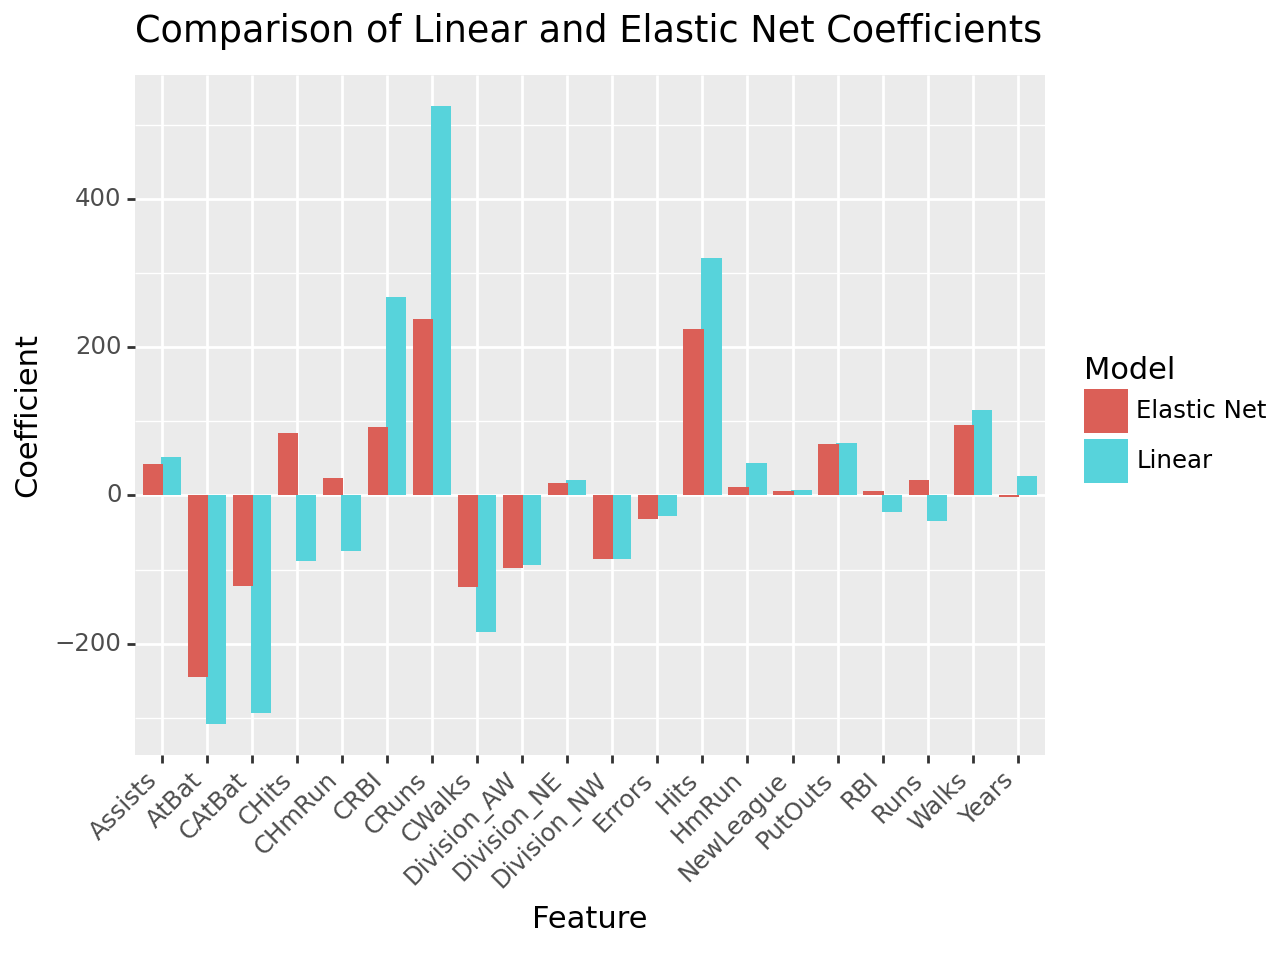

In [ ]:
# Removing prefixes from feature names in coef_df
coef_df['Feature'] = coef_df['Feature'].str.replace('standardize__', '').str.replace('dummify__', '')

# Creating a pandas dataframe from the sorted_coefs list
sorted_coefs_df = pd.DataFrame(sorted_coefs, columns=['Feature', 'Coefficient'])
sorted_coefs_df['Model'] = 'Linear'
coef_df['Model'] = 'Elastic Net'

# Combining the dataframes
df_combined = pd.concat([sorted_coefs_df, coef_df])

# Plotting
plot = (ggplot(df_combined, aes(x='Feature', y='Coefficient', fill='Model')) +
        geom_bar(stat='identity', position=position_dodge(width=0.8)) +
        labs(title='Comparison of Linear and Elastic Net Coefficients',
             x='Feature',
             y='Coefficient') +
        theme(axis_text_x=element_text(rotation=45, hjust=1))
       )

print(plot)

*    The Elastic Net Model's coefficients are closer to 0 than the Linear Model's and are generally less spread out. The CRuns variable for the Linear Model has the most influence on Salary and it's coefficient values are more erratic.

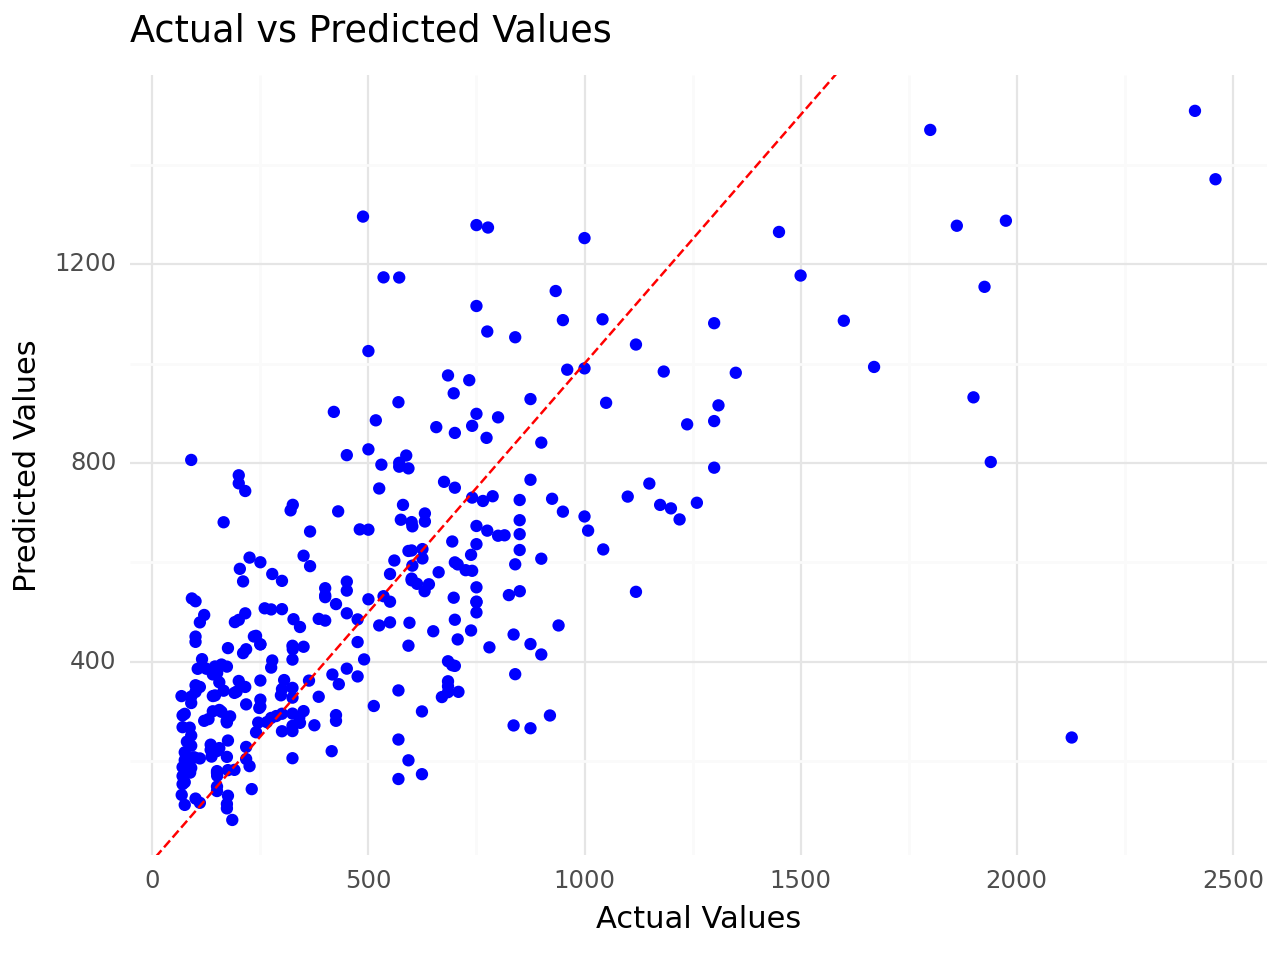

In [ ]:
from plotnine import ggplot, aes, geom_point, geom_abline, labs, theme_light

# Creating a dataframe with actual and predicted values
results_df = pd.DataFrame({
    'Actual': y,
    'Predicted': predictions
})

# Plotting the results
plot = (
    ggplot(results_df, aes(x='Actual', y='Predicted')) +
    geom_point(color='blue') +
    geom_abline(intercept=0, slope=1, color='red', linetype='dashed') +
    labs(x='Actual Values', y='Predicted Values', title='Actual vs Predicted Values') +
    theme_light()
)

print(plot)

*    Overall, the results look great, as our predicted values are close together with the actual values. There are some points that are further out, but they weren't considered to be outliers and they don't heavily influence the line of best fit.

# **Part V. Custom Model**

*    The final best pipeline from Part IV will be fitted on the original dataset with added variables.
*    The 7 new variables will be: batting average, career batting average, runs produced, career runs produced, on-base percentage, career on-base percentage, fielding percentage. Only the original dataset that was provided will be used.

Avg = Hits/AtBats, CAvg = CHits/CAtBats

RP = (CRuns + RBI)/2, CRP = (CRuns + CRBI)/2

Obp = (hits + walks)/AtBat, CObp = (CHits + CWalks)/CAtBat

FP = (PutOuts + Assists)/(PutOuts + Assists + Errors)

In [ ]:
# Creating a new dataframe
df_hitters_plus = df_hitters.copy()

# Calculating the new variables
df_hitters_plus['Avg'] = (df_hitters_plus['Hits'] / df_hitters_plus['AtBat']).round(3)
df_hitters_plus['CAvg'] = (df_hitters_plus['CHits'] / df_hitters_plus['CAtBat']).round(3)
df_hitters_plus['RP'] = (df_hitters_plus['Runs'] + df_hitters_plus['RBI']) / 2
df_hitters_plus['CRP'] = (df_hitters_plus['CRuns'] + df_hitters_plus['CRBI']) / 2
df_hitters_plus['Obp'] = ((df_hitters_plus['Hits'] + df_hitters_plus['Walks']) / df_hitters_plus['AtBat']).round(3)
df_hitters_plus['CObp'] = ((df_hitters_plus['CHits'] + df_hitters_plus['CWalks']) / df_hitters_plus['CAtBat']).round(3)
df_hitters_plus['FP'] = ((df_hitters_plus['PutOuts'] + df_hitters_plus['Assists']) / (df_hitters_plus['PutOuts'] + df_hitters_plus['Assists'] + df_hitters_plus['Errors'])).round(3)

# Display the dataframe with the new columns
df_hitters_plus.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,Errors,Salary,NewLeague,Avg,CAvg,RP,CRP,Obp,CObp,FP
0,293,66,1,30,29,14,1,293,66,1,...,20,149.65,0,0.225,0.225,29.5,29.5,0.273,0.273,0.960
1,315,81,7,24,38,39,14,3449,835,69,...,10,475.00,0,0.257,0.242,31.0,367.5,0.381,0.351,0.985
2,479,130,18,66,72,76,3,1624,457,63,...,14,480.00,0,0.271,0.281,69.0,245.0,0.430,0.443,0.986
3,496,141,20,65,78,37,11,5628,1575,225,...,3,500.00,0,0.284,0.280,71.5,833.0,0.359,0.343,0.986
4,321,87,10,39,42,30,2,396,101,12,...,4,91.50,0,0.271,0.255,40.5,47.0,0.364,0.338,0.995


In [ ]:
# Checking for NA values
na_values = df_hitters_plus.isna().sum()

print(na_values[na_values > 0])

FP    15
dtype: int64


In [ ]:
# Find rows where 'FP' column has NA values
na_rows = df_hitters_plus[df_hitters_plus['FP'].isna()]

# Display these rows
print(na_rows[['PutOuts', 'Assists', 'Errors']])

     PutOuts  Assists  Errors
9          0        0       0
38         0        0       0
52         0        0       0
65         0        0       0
125        0        0       0
132        0        0       0
149        0        0       0
158        0        0       0
186        0        0       0
196        0        0       0
198        0        0       0
207        0        0       0
249        0        0       0
251        0        0       0
267        0        0       0


In [ ]:
# Converting NaN values for Fielding% to 0
df_hitters_plus['FP'].fillna(0, inplace=True)

In [ ]:
# Checking for NA values again
na_values = df_hitters_plus.isna().sum()

print(na_values[na_values > 0])

Series([], dtype: int64)


In [ ]:
df_hitters_plus

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,Errors,Salary,NewLeague,Avg,CAvg,RP,CRP,Obp,CObp,FP
0,293,66,1,30,29,14,1,293,66,1,...,20,149.65,0,0.225,0.225,29.5,29.5,0.273,0.273,0.960
1,315,81,7,24,38,39,14,3449,835,69,...,10,475.00,0,0.257,0.242,31.0,367.5,0.381,0.351,0.985
2,479,130,18,66,72,76,3,1624,457,63,...,14,480.00,0,0.271,0.281,69.0,245.0,0.430,0.443,0.986
3,496,141,20,65,78,37,11,5628,1575,225,...,3,500.00,0,0.284,0.280,71.5,833.0,0.359,0.343,0.986
4,321,87,10,39,42,30,2,396,101,12,...,4,91.50,0,0.271,0.255,40.5,47.0,0.364,0.338,0.995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,...,3,700.00,0,0.256,0.298,56.5,345.0,0.330,0.349,0.991
318,492,136,5,76,50,94,12,5511,1511,39,...,20,875.00,0,0.276,0.274,63.0,674.0,0.467,0.433,0.972
319,475,126,3,61,43,52,6,1700,433,7,...,7,385.00,0,0.265,0.255,52.0,155.0,0.375,0.341,0.955
320,573,144,9,85,60,78,8,3198,857,97,...,12,960.00,0,0.251,0.268,72.5,445.0,0.387,0.372,0.992


In [ ]:
# Creating response and predictor variables from df_hitters_plus
X1 = df_hitters_plus.drop('Salary', axis=1)
y1 = df_hitters_plus['Salary']

**Linear Model: All Variables from the df_hitters_plus dataframe**

In [ ]:
# Linear Regression pipeline
lr_pipeline = Pipeline(
    [("preprocessing", ct),
     ("linear_regression", LinearRegression())]
)

# Performing cross-validation for R-squared
linear_scores = cross_val_score(lr_pipeline, X1, y1, cv=5, scoring='r2')
print("Linear R-squared Scores")
print(linear_scores)
print()

# Performing cross-validation for MSE
mse_scores = cross_val_score(lr_pipeline, X1, y1, cv=5, scoring='neg_mean_squared_error')
print("MSE Scores:")
print(-(mse_scores))
print()

# Fitting the model on the whole dataset
lr_pipeline.fit(X1, y1)

# Getting the coefficients
linear_coefs = lr_pipeline.named_steps['linear_regression'].coef_

# Extracting feature names
feature_names = (lr_pipeline.named_steps['preprocessing']
                 .transformers_[0][1]
                 .get_feature_names_out(input_features=X1.select_dtypes(include=[object]).columns.tolist())
                 .tolist() +
                 X1.select_dtypes(include=[np.number]).columns.tolist())

# Pairing coefficients with feature names
coefs_with_names = list(zip(feature_names, linear_coefs))

# Sorting the coefficients by their absolute values
sorted_coefs_plus = sorted(coefs_with_names, key=lambda x: abs(x[1]), reverse=True)

# Displaying the most significant coefficients
print("Most significant coefficients:")
for feature, coef in sorted_coefs_plus[:10]:
    print(f"{feature}: {coef}")

Linear R-squared Scores
[-0.06089848  0.48968678  0.60767979  0.26407403  0.20957782]

MSE Scores:
[103937.2457093  130849.63383576  81251.56451934 125116.60031834
 105461.08980643]

Most significant coefficients:
AtBat: -710.7251281874914
CHits: -650.689201621614
Hits: 644.0889299443762
CRuns: 422.8304181755999
Walks: 304.1587708145672
CRP: 287.1058158262309
CWalks: -214.23535292141418
Obp: -201.8006653460401
CAtBat: 188.58741485103855
CRBI: 142.87975724282023


**Elastic Net Model: All Variables from the df_hitters_plus dataframe**

In [ ]:
# Transforming the features of df_hitters_plus
X1_preprocessed = ct.fit_transform(X1)

# Fitting the Elastic Net model
elastic_net_model.fit(X1_preprocessed, y1)

# Making predictions
predictions1 = elastic_net_model.predict(X1_preprocessed)

# Evaluating the model
mse1 = mean_squared_error(y1, predictions1)
r21 = r2_score(y1, predictions1)

print(f"MSE on df_hitters_plus: {mse1:.2f}")
print(f"R2 Score on df_hitters_plus: {r21:.2f}")

MSE on df_hitters_plus: 80452.97
R2 Score on df_hitters_plus: 0.55


*    The Elastic Net Model, tuned with the best pipeline from part 4, was fitted onto the new df_hitters_plus dataset with 7 new metrics. It had an MSE of 80452.97, the lowest so far, and an R2 score of 0.55, the highest so far.

In [ ]:
# Getting the coefficients
coefficients = elastic_net_model.coef_

# Getting the feature names after transformation
feature_names = ct.get_feature_names_out()

# Creating a DataFrame for coefficients
coef_df_plus = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sorting the coefficients by their absolute values but keeping their original sign
coef_df_plus['abs_coef'] = coef_df_plus['Coefficient'].abs()
coef_df_plus = coef_df_plus.sort_values(by='abs_coef', ascending=False).drop('abs_coef', axis=1)

print(coef_df_plus)

                   Feature  Coefficient
3       standardize__AtBat  -410.136938
4        standardize__Hits   305.768337
8       standardize__Walks   216.742087
13      standardize__CRuns   153.784923
24        standardize__Obp  -142.157082
21       standardize__CAvg   112.315696
15     standardize__CWalks  -102.290487
23        standardize__CRP    97.702569
2     dummify__Division_NW   -84.302513
0     dummify__Division_AW   -72.639768
10     standardize__CAtBat   -71.356201
16    standardize__PutOuts    58.095205
17    standardize__Assists    44.125613
14       standardize__CRBI    38.648268
12     standardize__CHmRun    32.053295
9       standardize__Years    30.008330
20        standardize__Avg   -27.805977
18     standardize__Errors   -26.175777
26         standardize__FP    21.103538
7         standardize__RBI    19.552142
11      standardize__CHits   -17.169586
22         standardize__RP    16.285754
1     dummify__Division_NE    15.486832
19  standardize__NewLeague    11.193904


*     It's worth noting that the newly created variable of on-base percentage was 5th as well as career batting average at 6th. Career runs produced was 8th and fielding percentage was 19th. 1986 batting average was 17th, 1986 runs produced was 22nd, and career on-base percentage was 25th. Creating a new metric for defense proved to not be significant, and the other defensive statistics were outside of the top 10 as well.

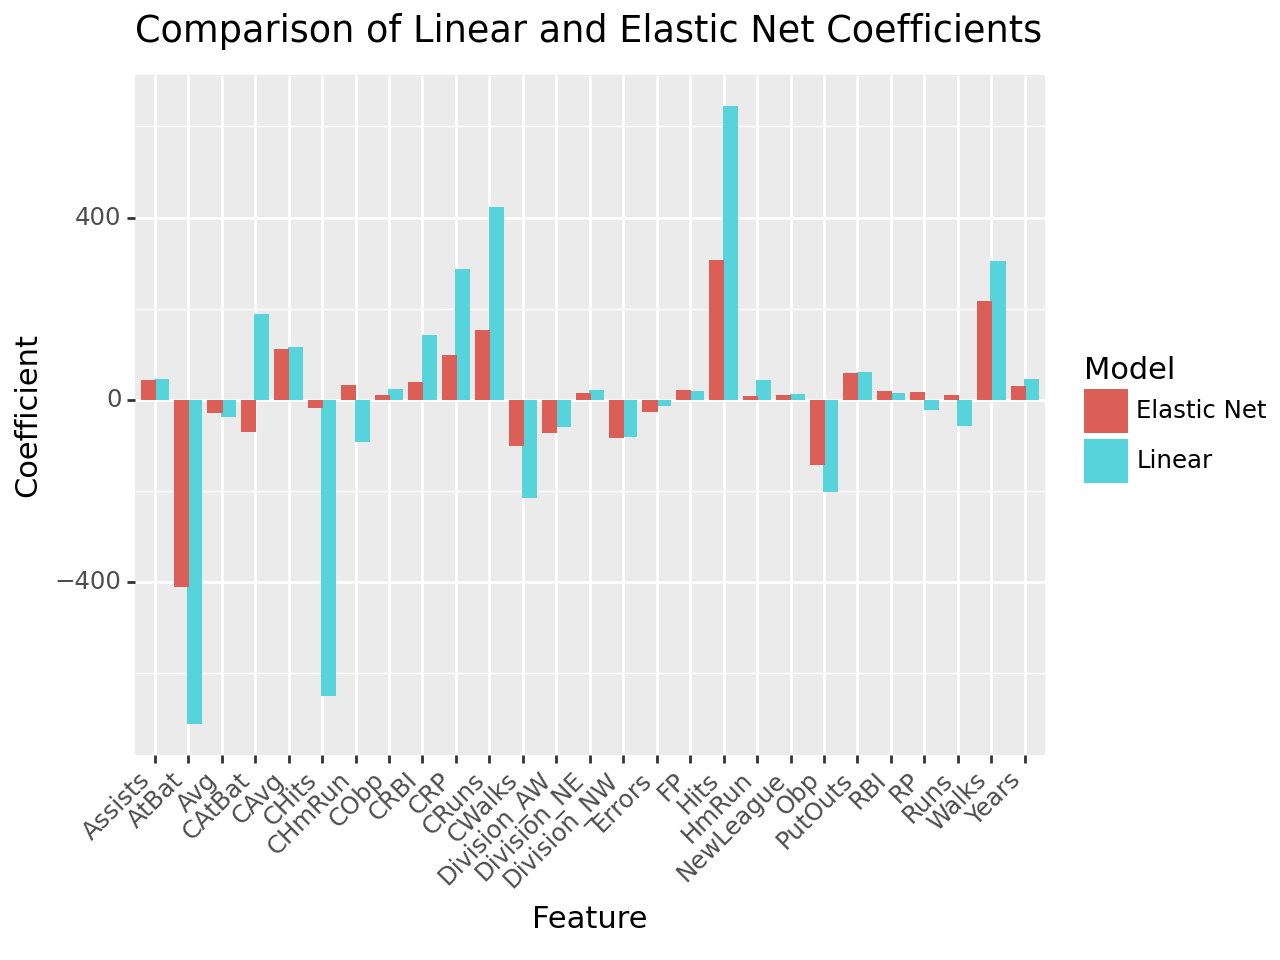

In [ ]:
# Removing prefixes from feature names in coef_df
coef_df_plus['Feature'] = coef_df_plus['Feature'].str.replace('standardize__', '').str.replace('dummify__', '')

# Creating a pandas dataframe from the sorted_coefs list
sorted_coefs_df = pd.DataFrame(sorted_coefs_plus, columns=['Feature', 'Coefficient'])
sorted_coefs_df['Model'] = 'Linear'
coef_df_plus['Model'] = 'Elastic Net'

# Combining the dataframes
df_combined = pd.concat([sorted_coefs_df, coef_df_plus])

# Plotting
plot = (ggplot(df_combined, aes(x='Feature', y='Coefficient', fill='Model')) +
        geom_bar(stat='identity', position=position_dodge(width=0.8)) +
        labs(title='Comparison of Linear and Elastic Net Coefficients',
             x='Feature',
             y='Coefficient') +
        theme(axis_text_x=element_text(rotation=45, hjust=1))
       )

print(plot)

*    The Linear Model's coefficients are much higher than the Elastic Net Model's, and the Elastic Net Model's coefficients are closer to 0 than the Linear Model.

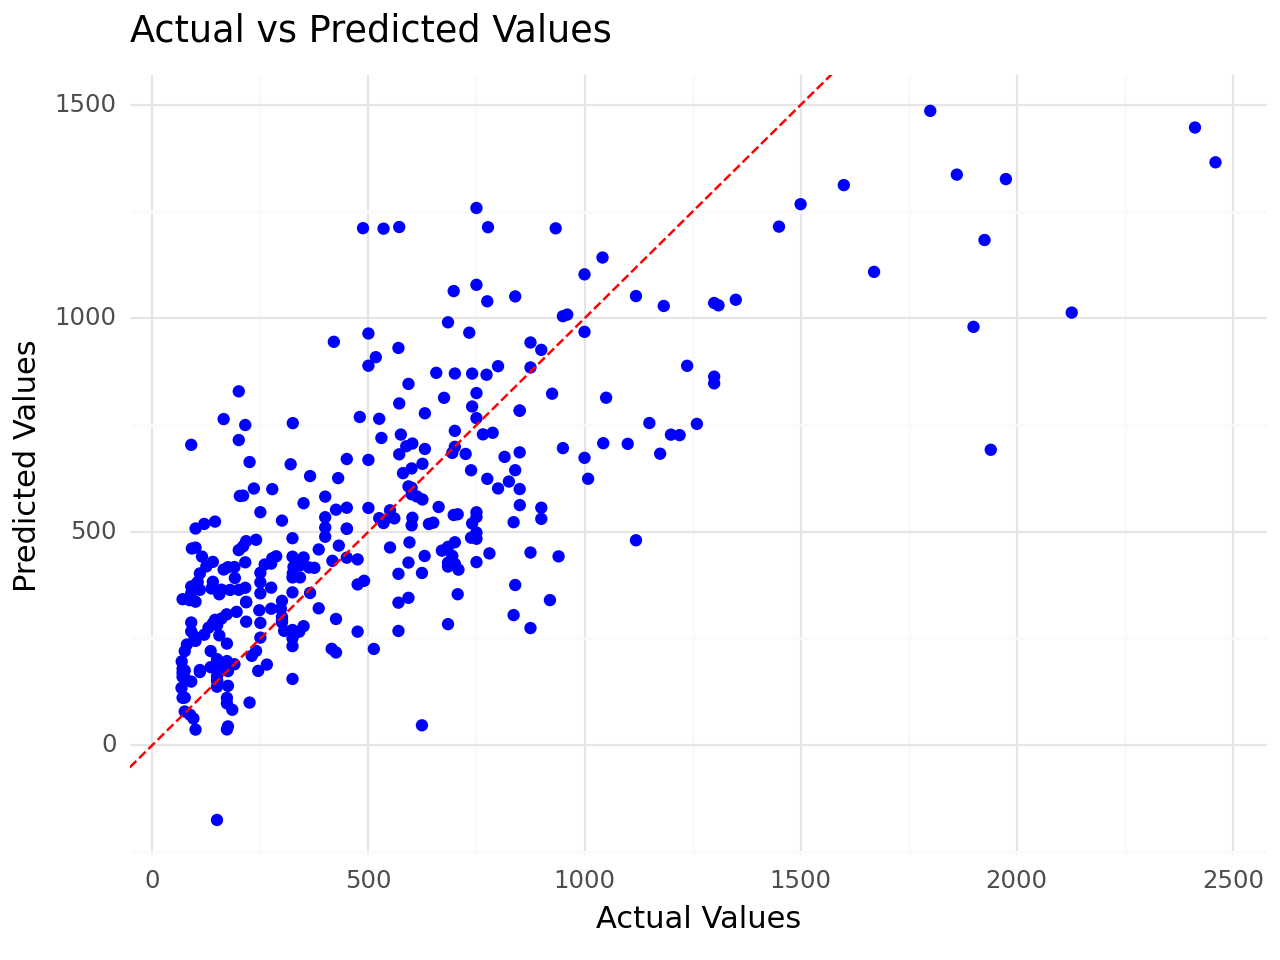

In [ ]:
from plotnine import ggplot, aes, geom_point, geom_abline, labs, theme_light

# Creating a dataframe with actual and predicted values
results_df = pd.DataFrame({
    'Actual': y,
    'Predicted': predictions1
})

# Plotting the results
plot = (
    ggplot(results_df, aes(x='Actual', y='Predicted')) +
    geom_point(color='blue') +
    geom_abline(intercept=0, slope=1, color='red', linetype='dashed') +
    labs(x='Actual Values', y='Predicted Values', title='Actual vs Predicted Values') +
    theme_light()
)

print(plot)

*    The Actual and Predicted values are close together around the line of best fit, and that's a good sign that the model is performing well.